# Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 103 GB / percent used: 17.6 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [3]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

## Regrid

In [4]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Select zone

In [5]:
tas = tas.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
tas_era_regrid = tas_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Compute clim

In [6]:
tas_clim = tas.mean('time')
tas_era_regrid_clim = tas_era_regrid.mean('time')

In [7]:
tas_bias = tas_clim-tas_era_regrid_clim

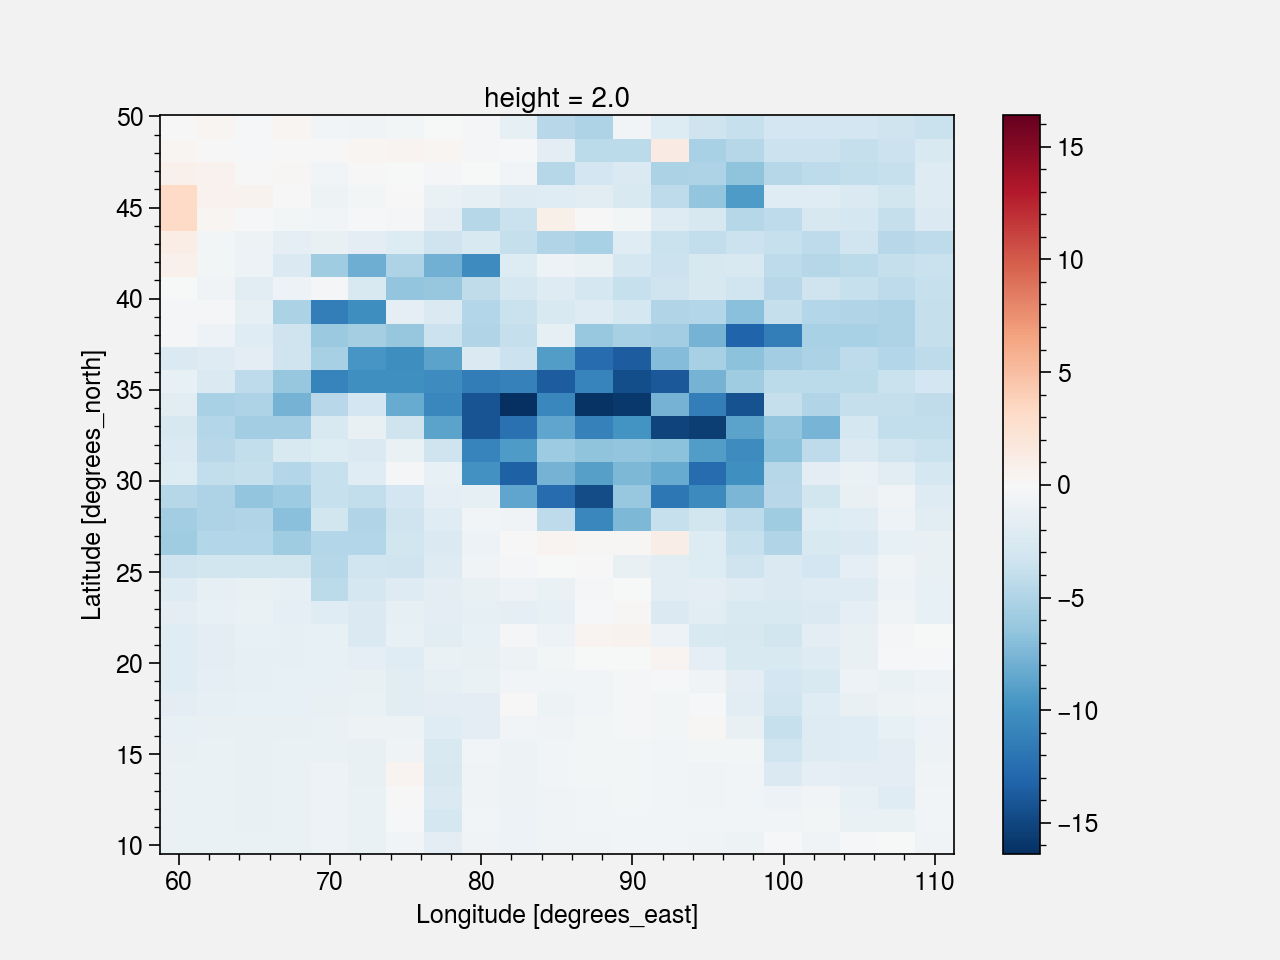

In [8]:
tas_bias.plot()

In [9]:
tas_bias.max()

<xarray.DataArray ()>
array(3.31948477)
Coordinates:
    height   float64 2.0

In [10]:
tas_bias.min()

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    height   float64 2.0

In [14]:
tas.lon.values

array([ 60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,
        82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5, 100. , 102.5,
       105. , 107.5, 110. ], dtype=float32)

In [15]:
tas.lat.values

array([10.140845, 11.408451, 12.676056, 13.943662, 15.211267, 16.478872,
       17.746479, 19.014084, 20.28169 , 21.549295, 22.816902, 24.084507,
       25.352112, 26.619719, 27.887323, 29.15493 , 30.422535, 31.690142,
       32.957745, 34.225353, 35.492958, 36.760563, 38.028168, 39.295776,
       40.56338 , 41.830986, 43.09859 , 44.366196, 45.633804, 46.90141 ,
       48.169014, 49.43662 ], dtype=float32)

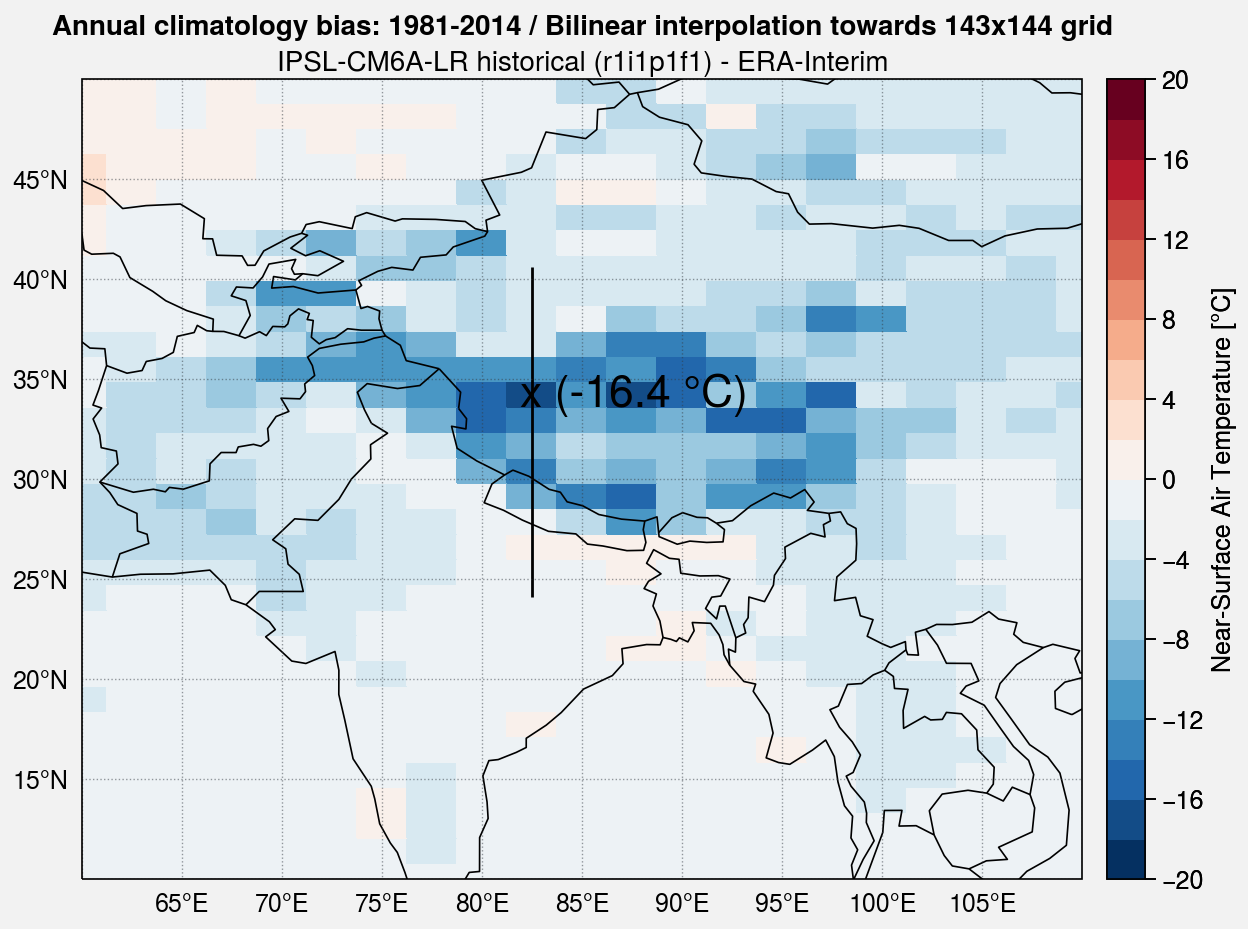

In [8]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')

# Add boxes
# for ax in axs:
#     u.plot_zones_IPSL_CM6A_LR(ax)
    
axs[0].add_patch(mpatches.Rectangle(
    xy=[82.5, 24.084507], width=0, height=40.56338-24.084507,
    transform=ccrs.PlateCarree(), fill=False
))
axs[0].text(82.5-dx/4, 34.225353-dy/2, 'x (-16.4 °C)', fontsize=16, 
#             horizontalalignment='center', verticalalignment='center'
           )

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=5, latlines=5, abc=False, latlim=latlim, lonlim=lonlim
)

# var = 'ta'
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias.png')
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias.pdf')

In [13]:
tas_bias.sel(lat=34.225353, lon=82.5)

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    lat      float32 34.225353
    lon      float32 82.5
    height   float64 2.0

In [58]:
tas_bias.sel(lat=30.422535, lon=82.5)

<xarray.DataArray ()>
array(-13.37309474)
Coordinates:
    lat      float32 30.422535
    lon      float32 82.5
    height   float64 2.0

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [9]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [10]:
ps_era_regrid = regridder(ps_era)

ps = ps.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ps_era_regrid = ps_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

ps_clim = ps.mean('time')
ps_era_regrid_clim = ps_era_regrid.mean('time')

# Load Air Temperature

In [11]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var].load()-273.15

ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).load()-273.15

In [12]:
ta_era_regrid = regridder(ta_era)

ta = ta.sel(lat=slice(24.084507,40.56338), lon=82.5).load()
ta_era_regrid = ta_era_regrid.sel(lat=slice(24.084507,40.56338), lon=82.5).load()

ta_clim = ta.mean('time', skipna=False)
ta_era_regrid_clim = ta_era_regrid.mean('time', skipna=False)

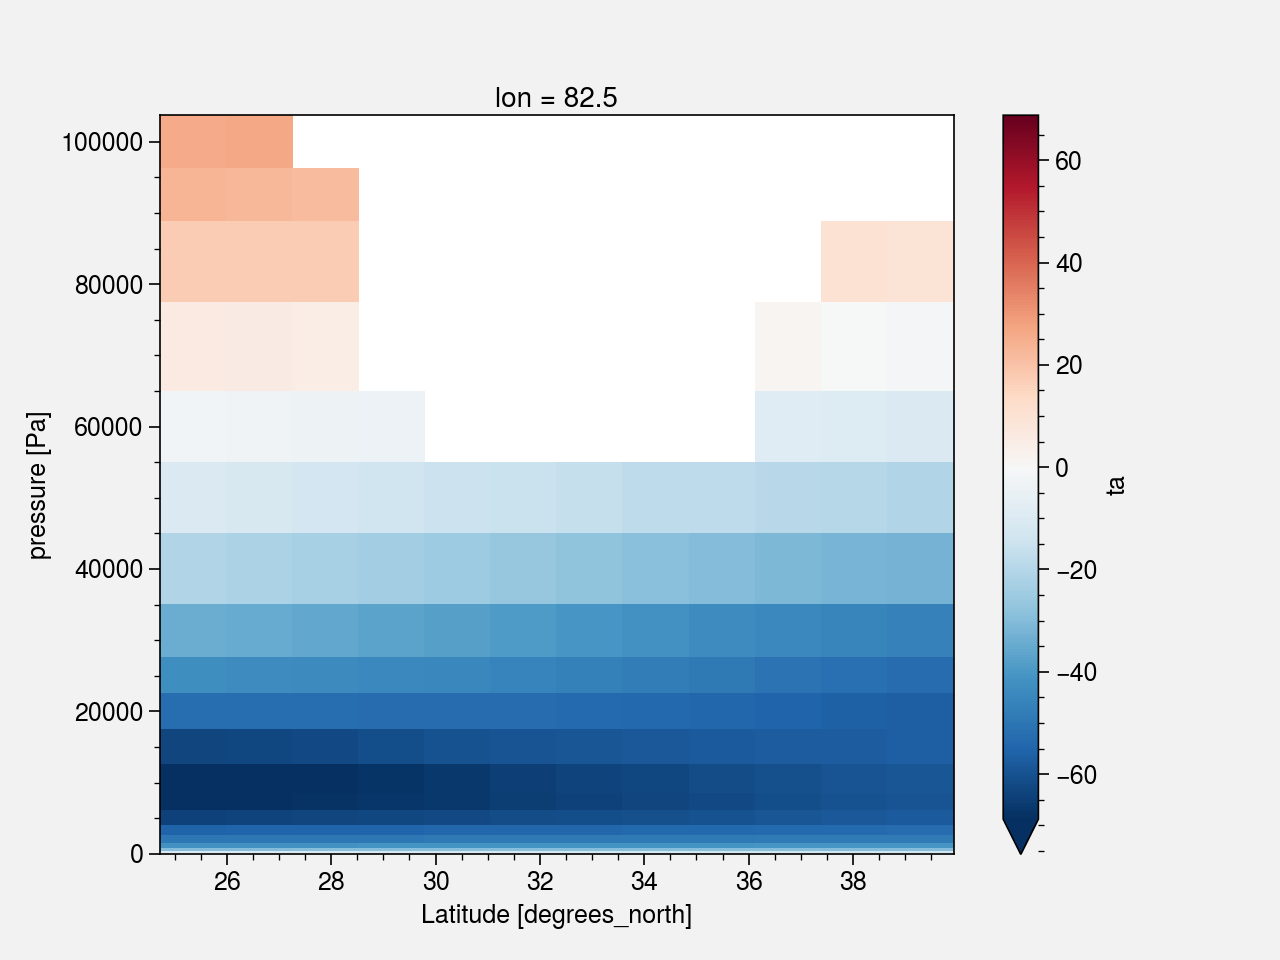

In [81]:
ta_clim.plot(robust=True)

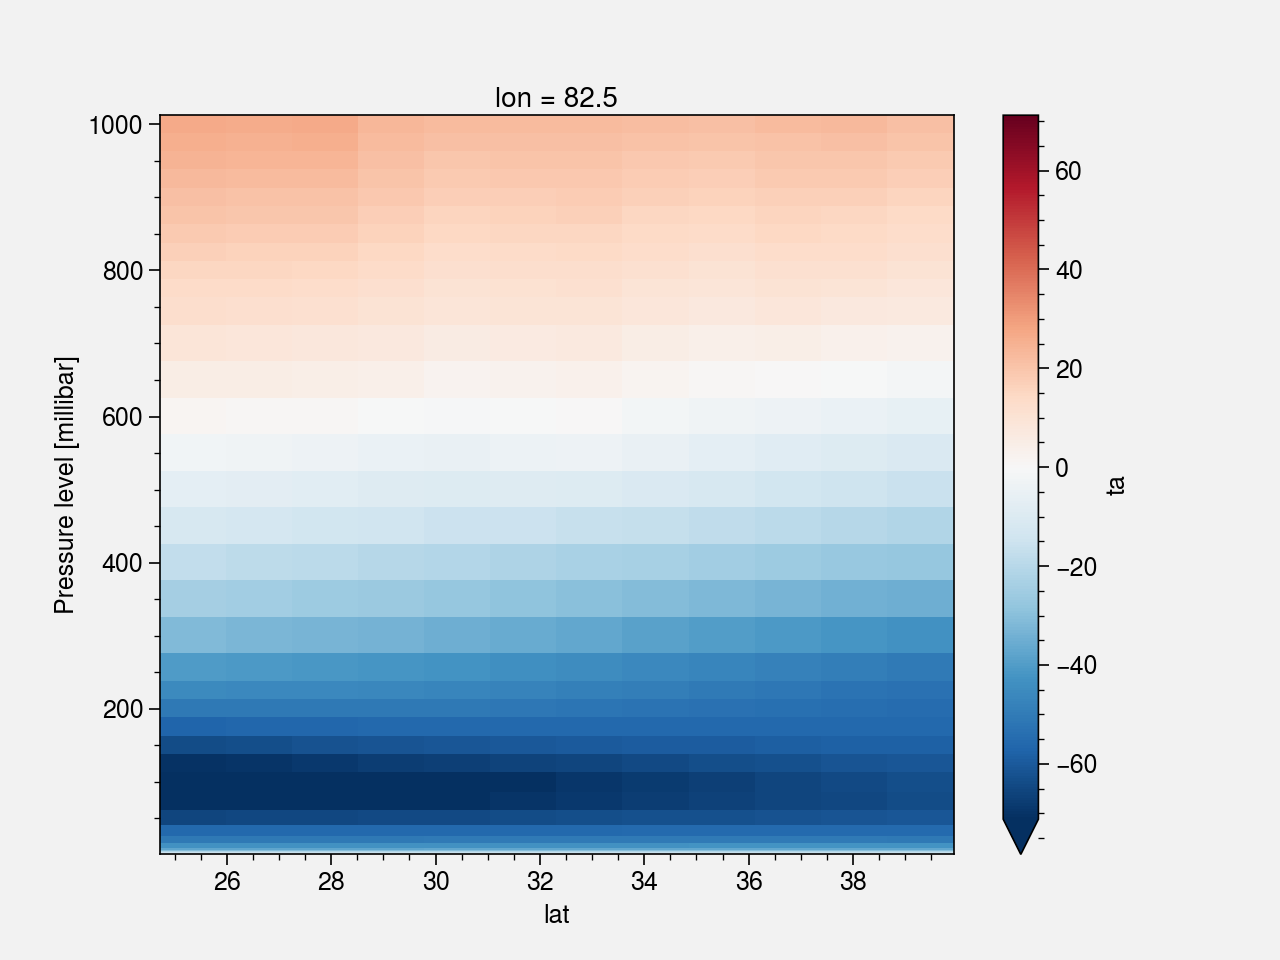

In [27]:
ta_era_regrid_clim.plot(robust=True)

In [13]:
ps_clim = ps_clim.sel(lat=slice(24.084507,40.56338), lon=82.5)

ps_era_regrid_clim = ps_era_regrid_clim.sel(lat=slice(24.084507,40.56338), lon=82.5)
ps_era_regrid_clim

<xarray.DataArray 'sp' (lat: 12)>
array([99192.67822083, 99959.43794958, 92744.67949447, 66776.06557094,
       54574.99104132, 53988.03075836, 55906.55960472, 53732.07387465,
       54795.30647383, 75523.67352787, 87805.07917856, 89316.82560936])
Coordinates:
    lon      float32 82.5
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776

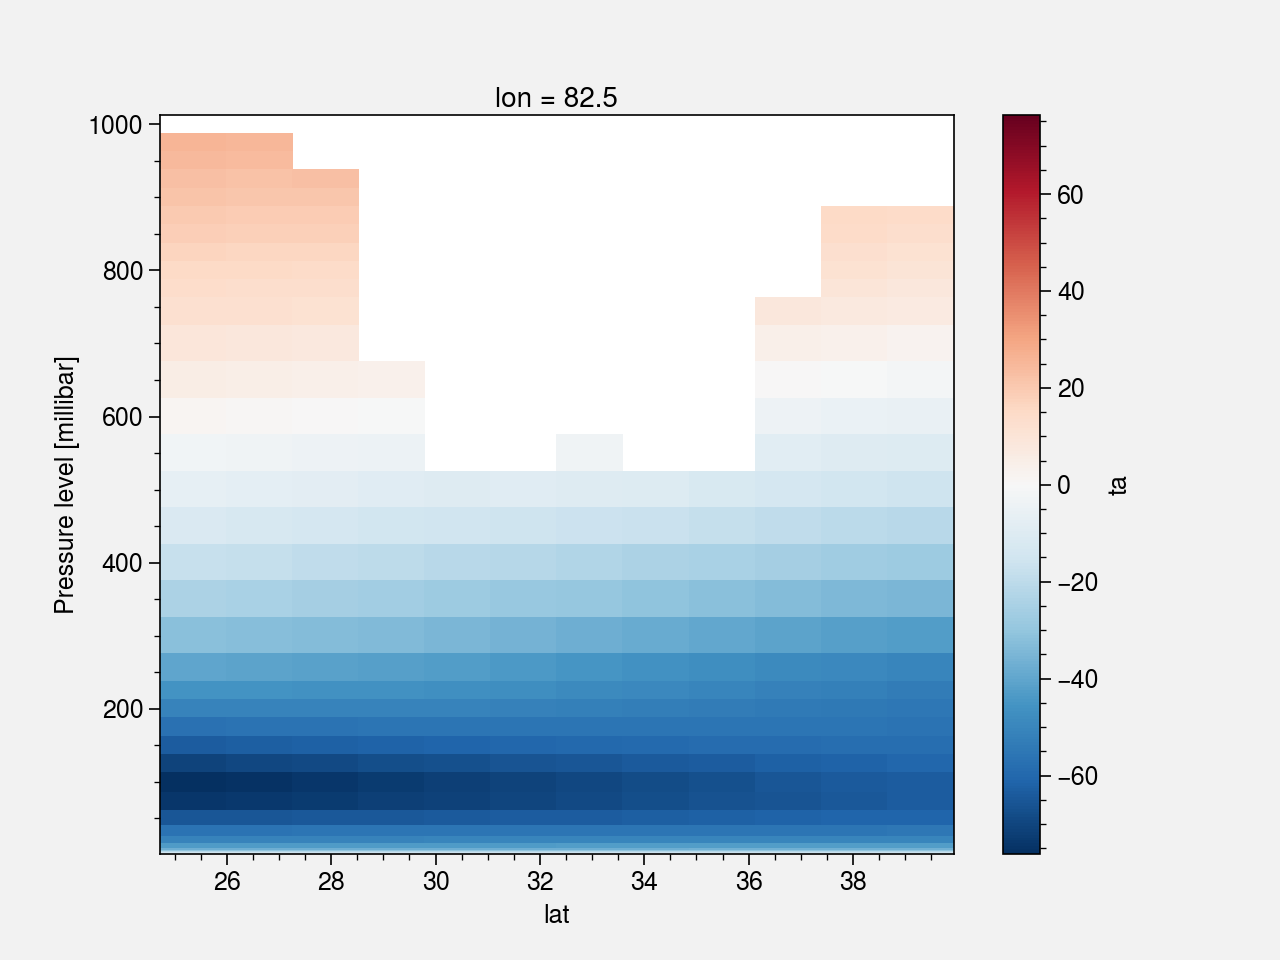

In [40]:
ta_era_regrid_clim.where(ta_era_regrid_clim.level <= ps_era_regrid_clim/100).plot()

In [14]:
ta_era_regrid_clim_masked = ta_era_regrid_clim.where(ta_era_regrid_clim.level <= ps_era_regrid_clim/100)

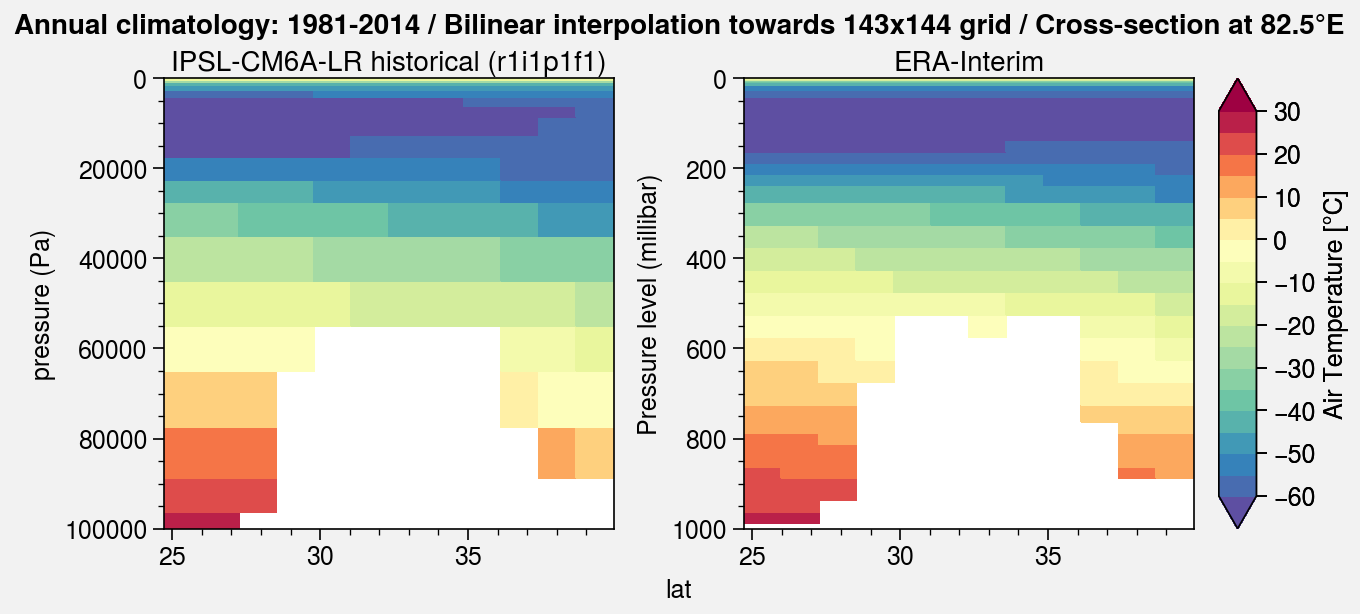

In [15]:
#Check colorbars 
levels = plot.arange(-60,30,5)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=2, sharey=0)

# Model
m = axs[0].pcolormesh(
    ta_clim, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')


# ERA-Interim
axs[1].pcolormesh(
    ta_era_regrid_clim_masked, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[1].format(ylim=(1000,0), title='ERA-Interim')

f.colorbar(m, label='Air Temperature [°C]')

axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon80_ta.png')
# f.save('img/ta/slice_lon80_ta.pdf')

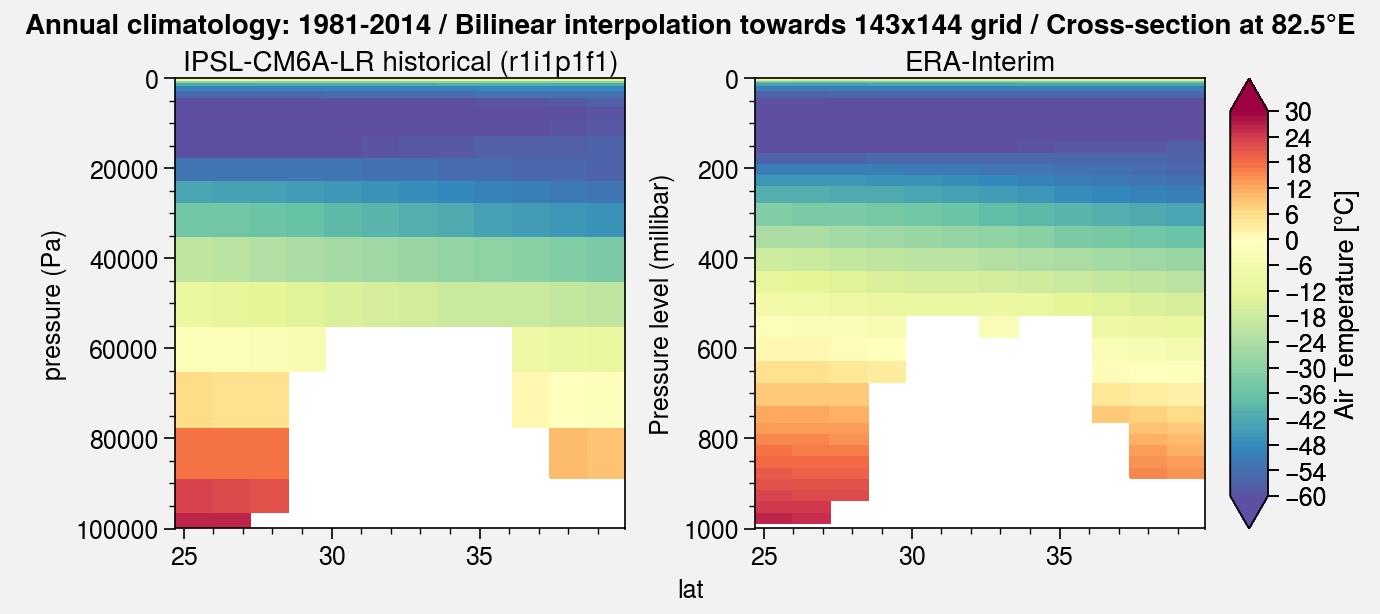

In [175]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=2, sharey=0)

# Model
m = axs[0].pcolormesh(
    ta_clim, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')


# ERA-Interim
axs[1].pcolormesh(
    ta_era_regrid_clim_masked, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[1].format(ylim=(1000,0), title='ERA-Interim')

f.colorbar(m, label='Air Temperature [°C]')

axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh.pdf')

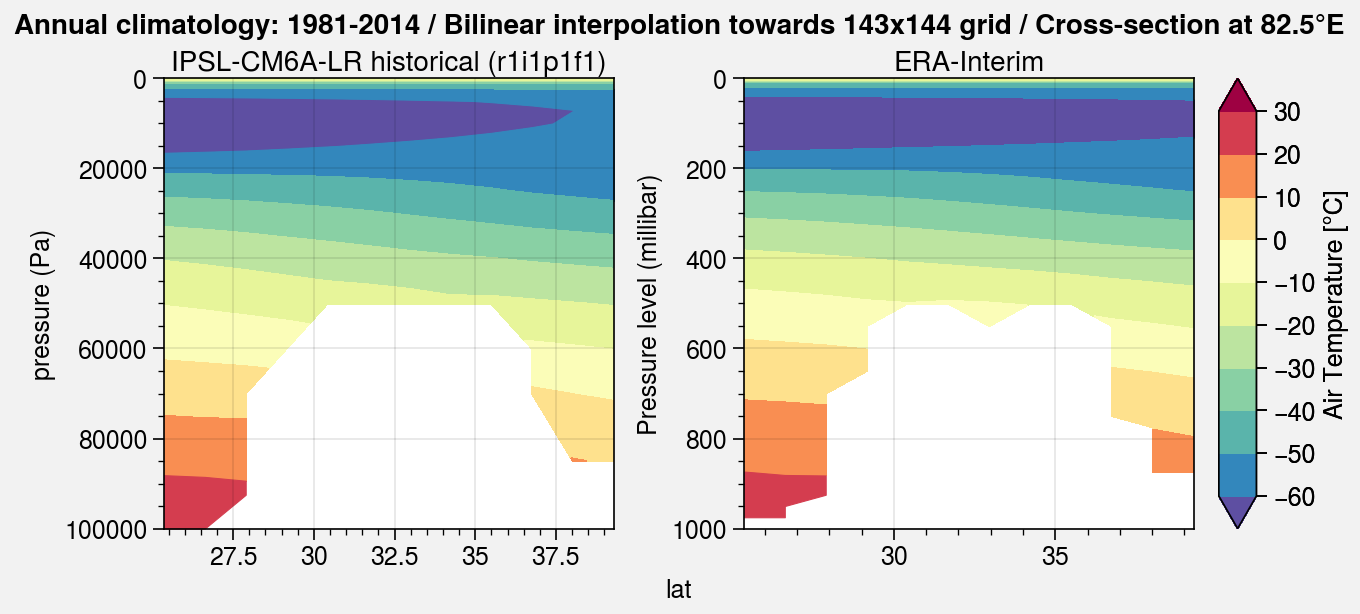

In [46]:
#Check colorbars 
levels = plot.arange(-60,30,10)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=2, sharey=0)

# Model
m = axs[0].contourf(
    ta_clim, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')


# ERA-Interim
axs[1].contourf(
    ta_era_regrid_clim_masked, cmap=cmap, levels=levels, norm='midpoint', 
    extend=extend,
#     colorbar='r'
)
axs[1].format(ylim=(1000,0), title='ERA-Interim')

f.colorbar(m, label='Air Temperature [°C]')

axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_contourf.png')
# f.save('img/ta/slice_lon_82_5_ta_contourf.pdf')

## Differences

In [47]:
ta_clim

<xarray.DataArray 'ta' (plev: 19, lat: 12)>
array([[ 26.320154 ,  26.445528 ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan],
       [ 23.153885 ,  22.898533 ,  21.612932 ,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan],
       [ 17.719902 ,  17.417746 ,  17.732307 ,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
         10.348926 ,   9.243632 ],
       [  6.173822 ,   5.7026634,   5.2659583,         nan,         nan,
                nan,         nan,         nan,         nan,   1.3099788,
         -0.1270277,  -1.1382463],
       [ -2.2134283,  -2.787271 ,  -3.463337 ,  -4.3006454,         nan,
                nan,         nan,         nan,         nan,  -8.332908 ,
         -9.280281 , -10.275264 ],
       [-10.450027 , -11.331272 , -12.373719 , -13.5193   , -14.8868   ,
        -15.249783 , -16.240908 , -18.011217 , -18.010014 , -18.899021 ,
        -19.735462 , -20.572601 ],
       [-20.567656 , -21.529613 , -22.673885 , -24.016811 , -25.238997 ,
        -26.521082 , -27.842438 , -28.939226 , -29.839462 , -30.973688 ,
        -31.90828  , -32.768696 ],
       [-34.003983 , -34.781498 , -35.722534 , -36.888813 , -38.015366 ,
        -39.23626  , -40.5888   , -41.879417 , -43.16929  , -44.54517  ,
        -45.59803  , -46.604996 ],
       [-42.508984 , -43.026318 , -43.65959  , -44.403362 , -45.158276 ,
        -46.09077  , -47.13234  , -48.201496 , -49.401215 , -50.71884  ,
        -51.73579  , -52.69717  ],
       [-52.471626 , -52.509407 , -52.630753 , -52.714005 , -52.85346  ,
        -53.167755 , -53.554787 , -54.02305  , -54.634422 , -55.303856 ,
        -55.97165  , -56.57832  ],
       [-63.272675 , -62.588654 , -61.85466  , -60.96761  , -60.154346 ,
        -59.46222  , -58.84895  , -58.328617 , -57.852383 , -57.45174  ,
        -57.15779  , -56.914406 ],
       [-71.328995 , -70.11133  , -68.781845 , -67.48452  , -66.23937  ,
        -65.01788  , -63.821285 , -62.647774 , -61.52855  , -60.489594 ,
        -59.518005 , -58.633465 ],
       [-69.7984   , -68.963486 , -68.08201  , -67.16141  , -66.16451  ,
        -65.117744 , -64.04927  , -62.995716 , -61.97031  , -60.98032  ,
        -60.034916 , -59.14894  ],
       [-64.01427  , -63.67324  , -63.252773 , -62.76843  , -62.216305 ,
        -61.63083  , -61.016388 , -60.375786 , -59.7159   , -59.05315  ,
        -58.39202  , -57.754482 ],
       [-55.418175 , -55.297886 , -55.159363 , -55.01362  , -54.834156 ,
        -54.639324 , -54.421146 , -54.17984  , -53.92112  , -53.655804 ,
        -53.378674 , -53.105324 ],
       [-49.87463  , -49.77916  , -49.67407  , -49.57509  , -49.45805  ,
        -49.343727 , -49.223377 , -49.097736 , -48.971718 , -48.85291  ,
        -48.727818 , -48.607323 ],
       [-41.55283  , -41.48988  , -41.412487 , -41.337875 , -41.24048  ,
        -41.148285 , -41.054653 , -40.95959  , -40.86749  , -40.78917  ,
        -40.712513 , -40.6516   ],
       [-29.60299  , -29.57939  , -29.555418 , -29.54832  , -29.52725  ,
        -29.52112  , -29.520067 , -29.522774 , -29.531704 , -29.556385 ,
        -29.580597 , -29.61458  ],
       [-10.762018 , -10.916853 , -11.093351 , -11.301911 , -11.519065 ,
        -11.766235 , -12.029776 , -12.297696 , -12.562302 , -12.824028 ,
        -13.057276 , -13.267237 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776
    lon      float32 82.5
  * plev     (plev) float32 100000.0 92500.0 85000.0 ... 1000.0 500.0 100.0

In [49]:
interp = ta_era_regrid_clim_masked.interp(level=(ta_clim.plev.values/100), method='linear')
interp

<xarray.DataArray 'ta' (level: 19, lat: 12)>
array([[         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [ 23.10341551,  22.56496944,  22.69919297,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [ 18.56907433,  18.17487835,  18.01811305,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,  14.39907962,  13.32072671],
       [  8.99674706,   8.652425  ,   8.18475271,          nan,
                 nan,          nan,          nan,          nan,
                 nan,   4.54627842,   3.83346457,   2.80726182],
       [  1.56579415,   1.09619546,   0.55834466,  -0.20601681,
                 nan,          nan,          nan,          nan,
                 nan,  -3.60503209,  -4.78132799,  -5.92067522],
       [ -6.89927698,  -7.50646359,  -8.245783  ,  -9.2890393 ,
         -9.88182823,  -9.29462807,  -9.72963518, -10.66182079,
        -12.11561898, -13.67482444, -14.68578953, -15.76276665],
       [-17.68370145, -18.38137564, -19.16915362, -20.06862427,
        -21.02462059, -21.93436494, -22.91560283, -23.84656754,
        -24.80053478, -25.91414363, -26.87965274, -27.78366996],
       [-31.67175139, -32.27687746, -32.99144344, -33.88026107,
        -34.82052283, -35.94582389, -37.14483874, -38.37926426,
        -39.64924795, -40.77819927, -41.82141269, -42.83406529],
       [-40.45558826, -40.83893604, -41.31538663, -41.99657941,
        -42.73039274, -43.70230154, -44.78616467, -45.94244234,
        -47.17860756, -48.28765668, -49.37328838, -50.42128795],
       [-50.89946265, -50.84995173, -50.88198132, -50.99778156,
        -51.1531316 , -51.54388513, -52.0346779 , -52.58331004,
        -53.1943309 , -53.87000675, -54.43536092, -55.02485064],
       [-63.43745501, -62.85931895, -62.2685827 , -61.62358945,
        -61.01317649, -60.52068149, -60.00861786, -59.48865613,
        -58.98692152, -58.61355406, -58.25734696, -57.89005139],
       [-76.27893224, -75.27892523, -74.19469053, -73.04061645,
        -71.96128372, -70.7662636 , -69.44316549, -68.11621149,
        -66.82678722, -65.53889363, -64.35884839, -63.22681183],
       [-74.36616991, -73.71805907, -72.9682319 , -72.09118684,
        -71.06972629, -69.97372109, -68.8913859 , -67.80946952,
        -66.70423889, -65.59605198, -64.54122546, -63.54188742],
       [-65.23777277, -64.98686587, -64.70155868, -64.37670328,
        -64.01524056, -63.63187605, -63.22757472, -62.7852806 ,
        -62.32449002, -61.86289378, -61.36236209, -60.85378446],
       [-56.16238736, -56.07751204, -55.99002003, -55.89930754,
        -55.81555994, -55.74139105, -55.67817272, -55.61961891,
        -55.56243998, -55.51019649, -55.45683139, -55.40188323],
       [-50.82229287, -50.76712913, -50.71296503, -50.65837141,
        -50.61363172, -50.58133953, -50.56485929, -50.56271044,
        -50.5653665 , -50.57581896, -50.59154292, -50.62040227],
       [-43.08032106, -43.05469388, -43.03023638, -42.99884039,
        -42.97095628, -42.93652612, -42.8972923 , -42.85438253,
        -42.81256026, -42.78595813, -42.77022916, -42.77274676],
       [-30.86310976, -30.80378845, -30.74721399, -30.69527726,
        -30.64922941, -30.60794988, -30.57248082, -30.54385898,
        -30.52323095, -30.51388647, -30.51251945, -30.52698847],
       [-10.88294213, -11.04826199, -11.20587201, -11.35631435,
        -11.49669738, -11.62823412, -11.75031569, -11.8593923 ,
        -11.94909623, -12.02026165, -12.07963581, -12.12592499]])
Coordinates:
    lon      float32 82.5
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0

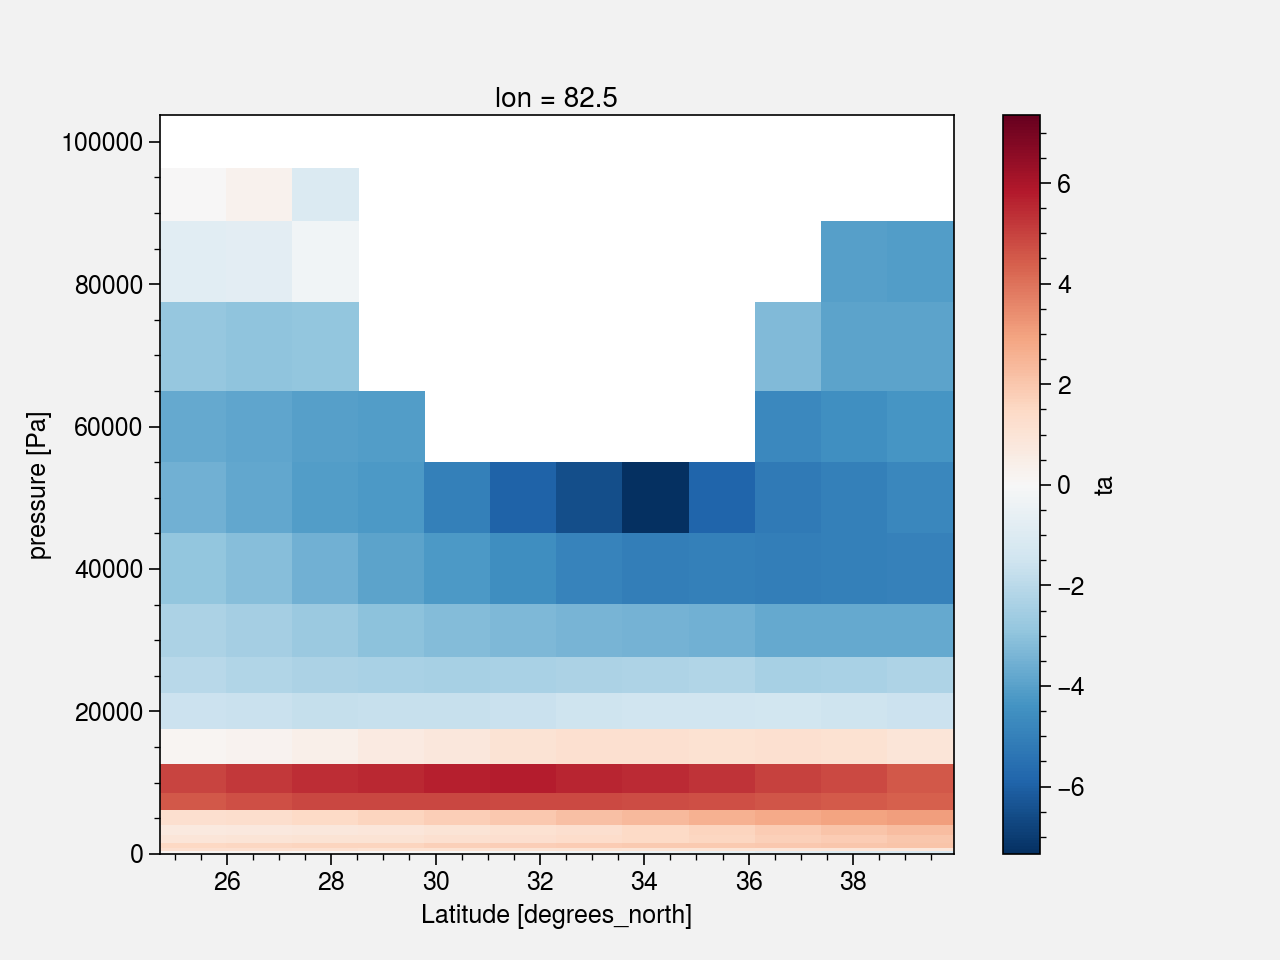

In [54]:
(ta_clim-interp.values).plot()

In [55]:
bias = ta_clim-interp.values

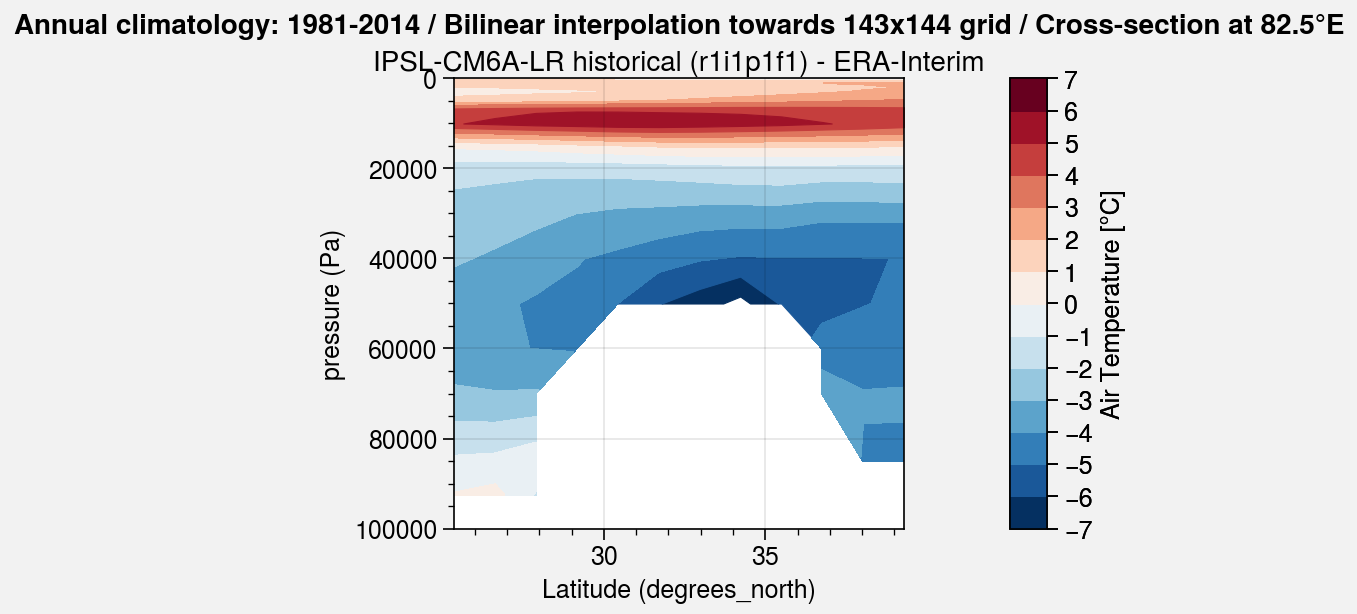

In [64]:
#Check colorbars 
levels = plot.arange(-7,7,1)
extend='both'
cmap='BuRd'

f, axs = plot.subplots(nrows=1, ncols=1)
# Model
m = axs[0].contourf(
    bias, cmap=cmap, 
    levels=levels, 
#     norm='midpoint', 
#     extend=extend,
#     colorbar='r'
)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')


f.colorbar(m, label='Air Temperature [°C]')

axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_contourf.png')
# f.save('img/ta/slice_lon_82_5_ta_contourf.pdf')

# Scatter plot on one pixel
lon=82.5, lat=34.225353 (-16.4 °C)

In [16]:
tas_clim_cs = tas_clim.sel(lon=82.5, lat=slice(24.084507,40.56338))
tas_era_regrid_clim_cs = tas_era_regrid_clim.sel(lon=82.5, lat=slice(24.084507,40.56338))

In [163]:
tas_clim_cs

<xarray.DataArray 'tas' (lat: 12)>
array([ 25.051111 ,  25.288565 ,  19.94118  ,  -4.2299275, -18.600424 ,
       -14.252912 , -15.711443 , -24.02109  , -19.870823 ,   2.8503754,
         8.930199 ,   8.979068 ], dtype=float32)
Coordinates:
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776
    lon      float32 82.5
    height   float64 2.0

In [162]:
tas_era_regrid_clim_cs

<xarray.DataArray 't2' (lat: 12)>
array([25.3927699 , 25.19009194, 20.62510441,  4.41001183, -5.22732907,
       -4.97622073, -3.51583043, -7.62469745, -8.8034385 ,  6.40700455,
       12.77321929, 12.62076676])
Coordinates:
    lon      float32 82.5
  * lat      (lat) float32 25.352112 26.619719 27.887323 ... 38.028168 39.295776

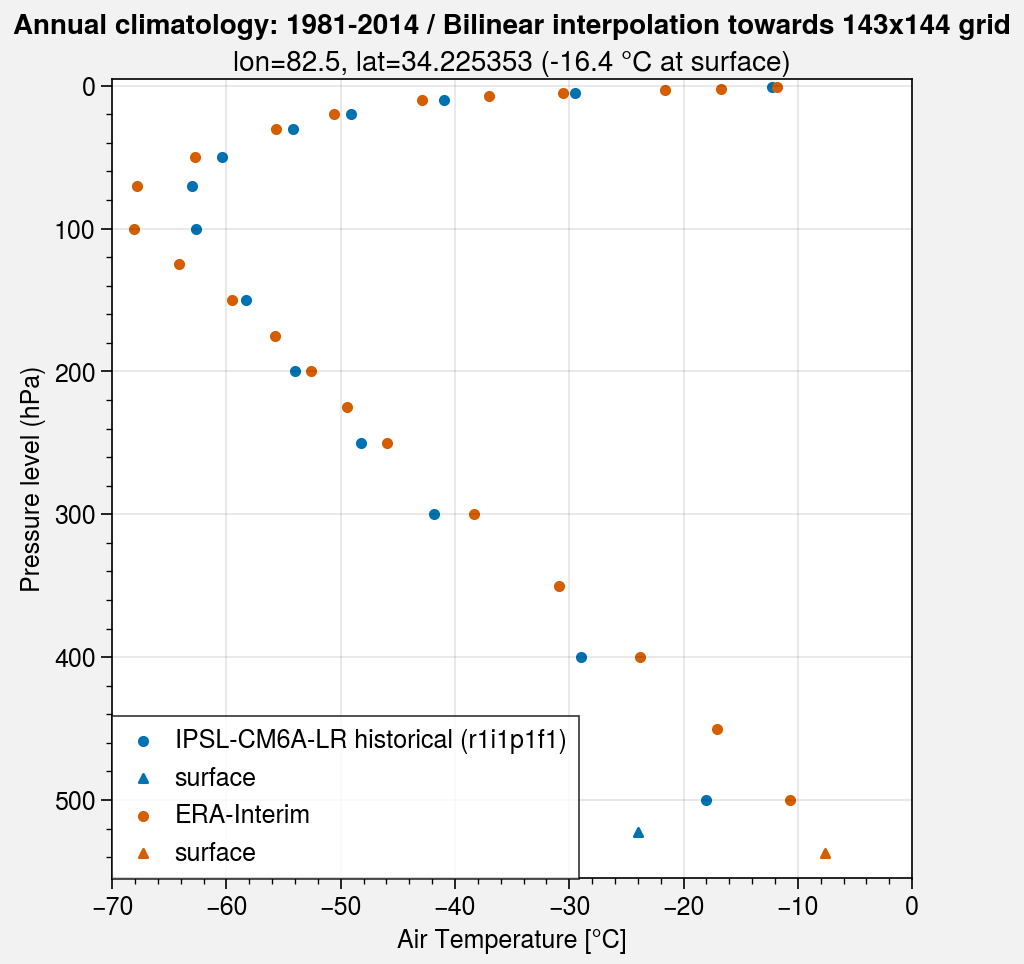

In [17]:
f, axs = plot.subplots(nrows=1, ncols=1, axwidth=4)

h1 = axs[0].scatter(ta_clim.sel(lat=34.225353).values, ta_clim.plev.values/100, label='IPSL-CM6A-LR historical (r1i1p1f1)')
h2 = axs[0].scatter(ta_era_regrid_clim_masked.sel(lat=34.225353).values, ta_era_regrid_clim.level.values, label='ERA-Interim')

h3 = axs[0].scatter(tas_clim_cs.sel(lat=34.225353).values, ps_clim.sel(lat=34.225353).values/100, color='C0', marker='^', label='surface')
h4 = axs[0].scatter(tas_era_regrid_clim_cs.sel(lat=34.225353).values, ps_era_regrid_clim.sel(lat=34.225353).values/100, color='C1', marker='^', label='surface')


hs = [h1, h3, h2, h4]

axs[0].legend(hs, ncols=1)
axs[0].format(title='lon=82.5, lat=34.225353 (-16.4 °C at surface)')

axs.format(
    ylim=(550+5,0-5), xlim=(-70,0), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid",
)

# f.save('img/ta/vertical_profile_lon_82_5_lat_34_ta.png')
# f.save('img/ta/vertical_profile_lon_82_5_lat_34_ta.pdf')

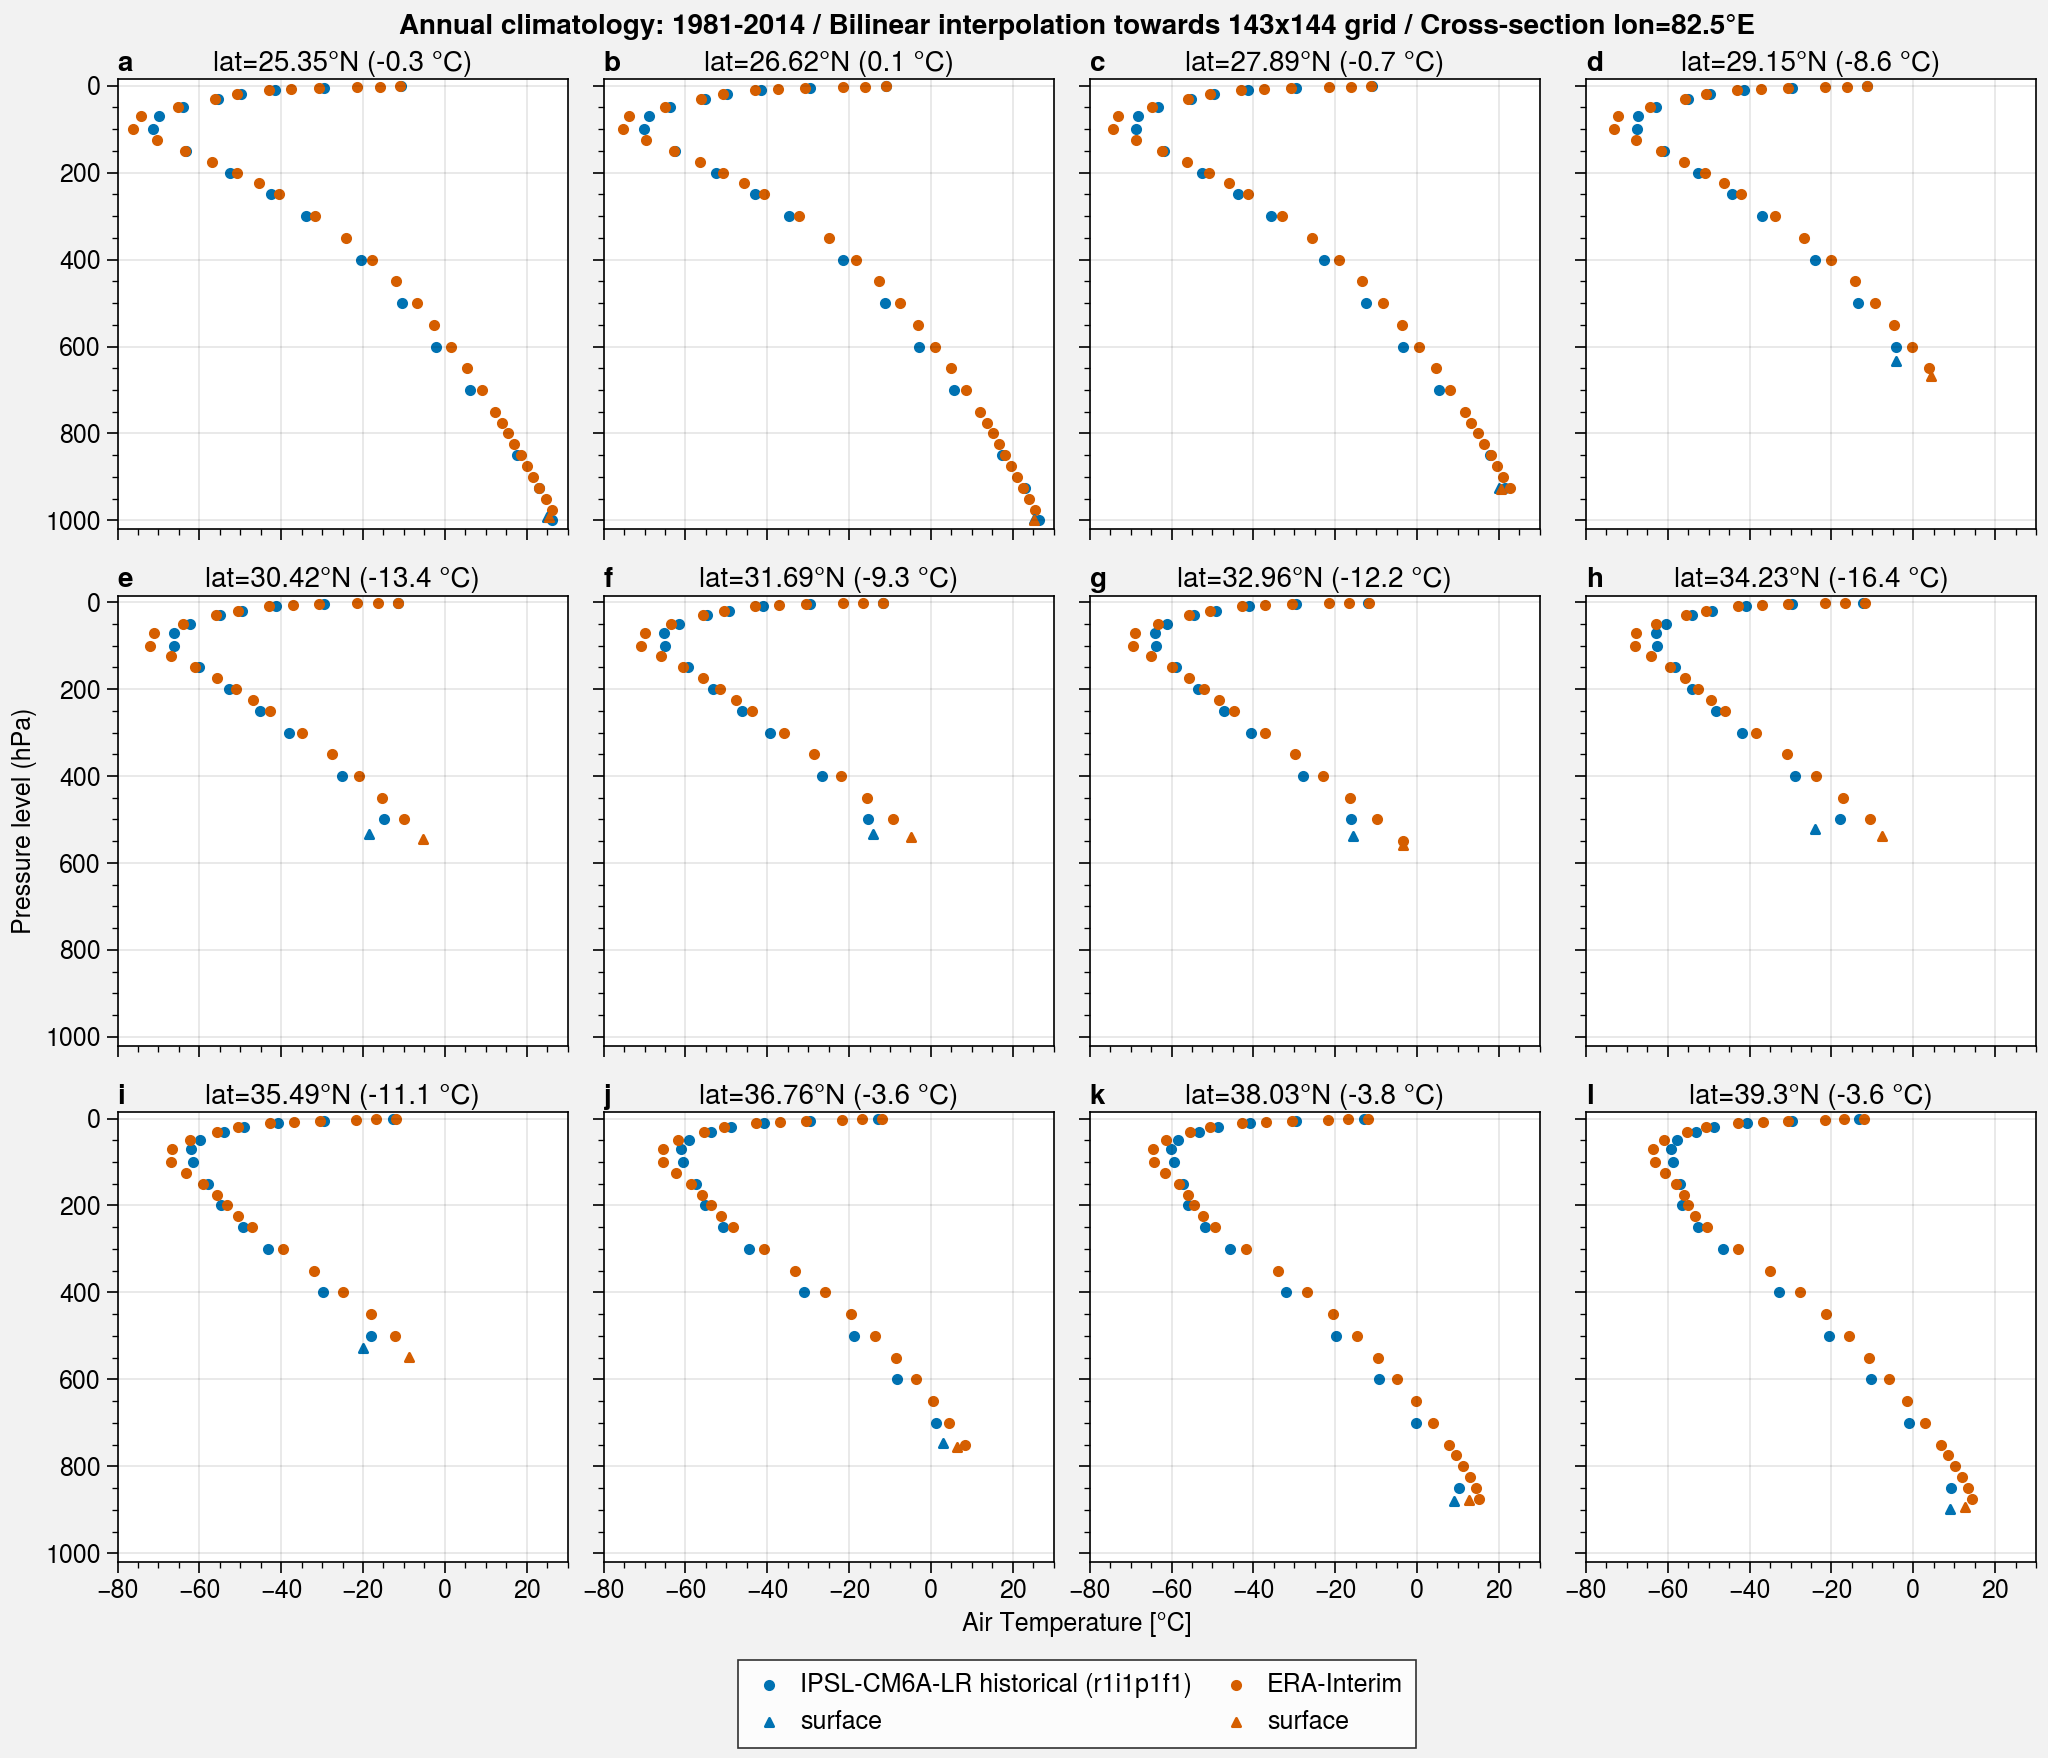

In [180]:
f, axs = plot.subplots(nrows=3, ncols=4)

for i, ax in enumerate(axs):
    h1 = ax.scatter(ta_clim.isel(lat=i).values, ta_clim.plev.values/100, label='IPSL-CM6A-LR historical (r1i1p1f1)')
    h2 = ax.scatter(ta_era_regrid_clim_masked.isel(lat=i).values, ta_era_regrid_clim.level.values, label='ERA-Interim')
    
    h3 = ax.scatter(tas_clim_cs.isel(lat=i).values, ps_clim.isel(lat=i).values/100, color='C0', marker='^', label='surface')
    h4 = ax.scatter(tas_era_regrid_clim_cs.isel(lat=i).values, ps_era_regrid_clim.isel(lat=i).values/100, color='C1', marker='^', label='surface')
    
    ax.format(title='lat='+str(np.round(ta_clim.isel(lat=i).lat.values, 2))+'°N ('+str(np.round(tas_bias.sel(lon=82.5, lat=slice(24.084507,40.56338)).isel(lat=i).values, 1))+' °C)')
    

    hs = [h1, h2, h3, h4]

f.legend(hs, loc='b', ncols=2)


axs.format(
    ylim=(1015+5,0-15), xlim=(-75-5,25+5), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section lon=82.5°E",
    abc=True
)

# f.save('img/ta/vertical_profile_lon_82_5_ta.png')
# f.save('img/ta/vertical_profile_lon_82_5_ta.pdf')

## Try to interpolate vertically

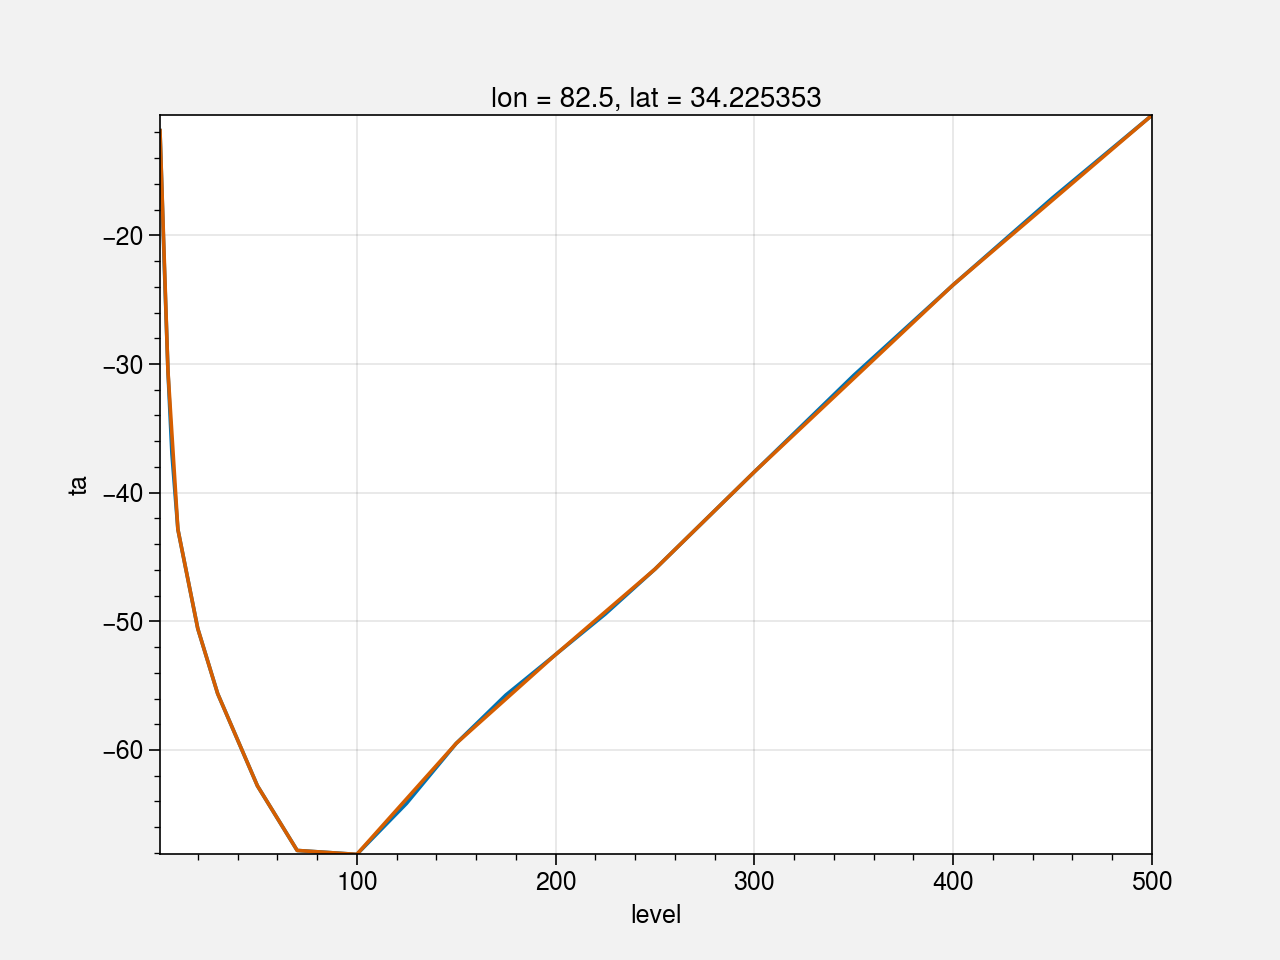

In [34]:
ta_era_regrid_clim_masked.sel(lat=34.225353).plot()
ta_era_regrid_clim_masked.sel(lat=34.225353).dropna('level').interp(
    level=(ta_clim.plev.values/100), 
    method='cubic'
).plot()

In [21]:
ta_era_regrid_clim_masked.sel(lat=34.225353).dropna('level').interp(
    level=(ta_clim.plev.values/100), 
    method='cubic'
) - ta_era_regrid_clim_masked.sel(lat=34.225353).dropna('level').interp(
    level=(ta_clim.plev.values/100), 
    method='linear'
)

<xarray.DataArray 'ta' (level: 19)>
array([            nan,             nan,             nan,             nan,
                   nan,  0.00000000e+00,  0.00000000e+00, -7.10542736e-15,
        7.10542736e-15, -7.10542736e-15,  7.10542736e-15,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.10542736e-15,  0.00000000e+00,
        7.10542736e-15, -3.55271368e-15,  0.00000000e+00])
Coordinates:
    lon      float32 82.5
    lat      float32 34.225353
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0

In [35]:
ta_era_regrid_clim_masked.sel(lat=34.225353).dropna('level').interp(
    level=(ta_clim.plev.values/100), 
    method='cubic'
)

<xarray.DataArray 'ta' (level: 19)>
array([         nan,          nan,          nan,          nan,
                nan, -10.66182079, -23.84656754, -38.37926426,
       -45.94244234, -52.58331004, -59.48865613, -68.11621149,
       -67.80946952, -62.7852806 , -55.61961891, -50.56271044,
       -42.85438253, -30.54385898, -11.8593923 ])
Coordinates:
    lon      float32 82.5
    lat      float32 34.225353
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0

In [40]:
ta_clim.sel(lat=30.422535).min()

<xarray.DataArray 'ta' ()>
array(-66.23937, dtype=float32)
Coordinates:
    lat      float32 30.422535
    lon      float32 82.5

In [37]:
ta_era_regrid_clim_masked.sel(lat=34.225353)

<xarray.DataArray 'ta' (level: 37)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, -10.66182079,
       -17.08441867, -23.84656754, -30.87859859, -38.37926426,
       -45.94244234, -49.42989401, -52.58331004, -55.72753744,
       -59.48865613, -64.15463928, -68.11621149, -67.80946952,
       -62.7852806 , -55.61961891, -50.56271044, -42.85438253,
       -36.98343929, -30.54385898, -21.61581729, -16.68445132,
       -11.8593923 ])
Coordinates:
  * level    (level) float64 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
    lon      float32 82.5
    lat      float32 34.225353

In [43]:
ta_era_regrid_clim_masked.sel(lat=30.422535)

<xarray.DataArray 'ta' (level: 37)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,  -9.88182823,
       -15.22245472, -21.02462059, -27.53412426, -34.82052283,
       -42.73039274, -46.86381799, -51.1531316 , -55.7684186 ,
       -61.01317649, -66.90750379, -71.96128372, -71.06972629,
       -64.01524056, -55.81555994, -50.61363172, -42.97095628,
       -37.20070943, -30.64922941, -21.57277836, -16.41349015,
       -11.49669738])
Coordinates:
  * level    (level) float64 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
    lon      float32 82.5
    lat      float32 30.422535

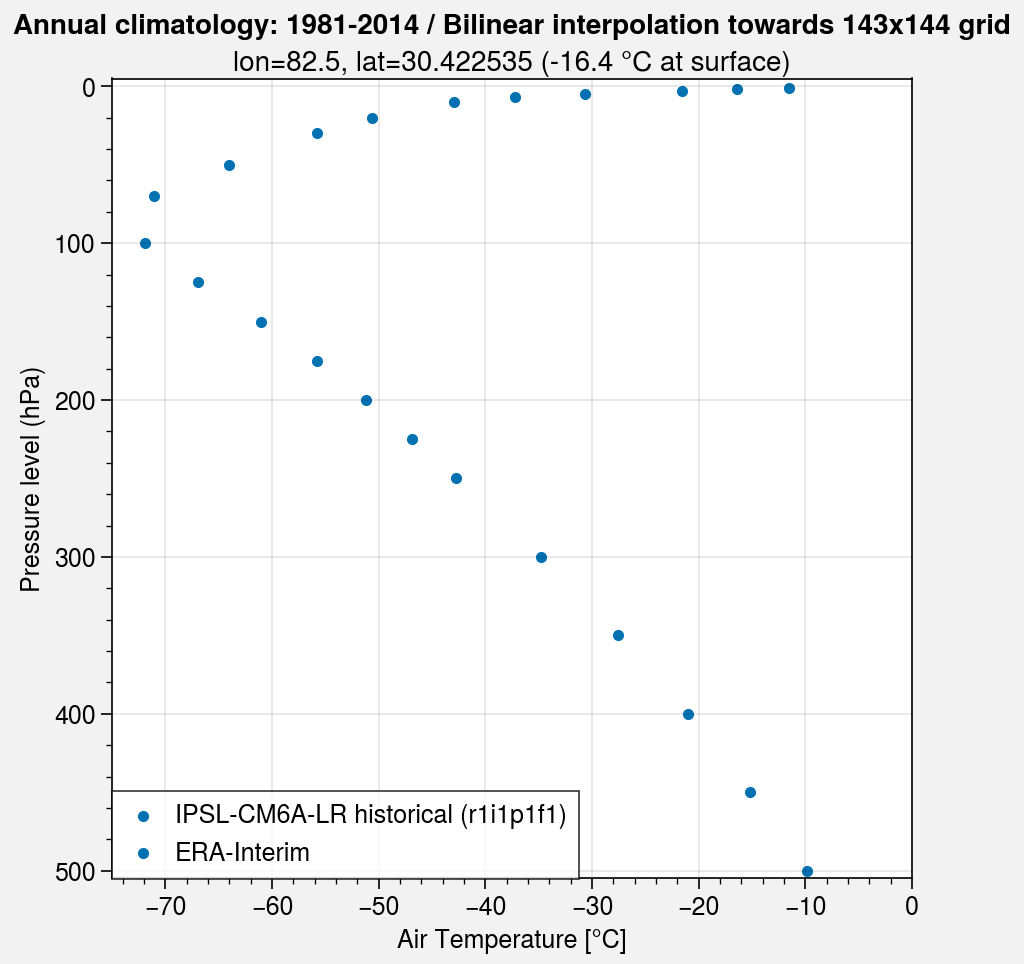

In [41]:
fig, axs = plot.subplots(nrows=1, ncols=1, axwidth=4)

# h1 = axs[0].scatter(ta_clim.sel(lat=30.422535).values, ta_clim.plev.values/100, label='IPSL-CM6A-LR historical (r1i1p1f1)')
h2 = axs[0].scatter(ta_era_regrid_clim_masked.sel(lat=30.422535).values, ta_era_regrid_clim.level.values, label='ERA-Interim')

hs = [h1, h2]

axs[0].legend(hs, ncols=1)
axs[0].format(title='lon=82.5, lat=30.422535 (-16.4 °C at surface)')

axs.format(
    ylim=(500+5,0-5), xlim=(-75,0), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid",
)


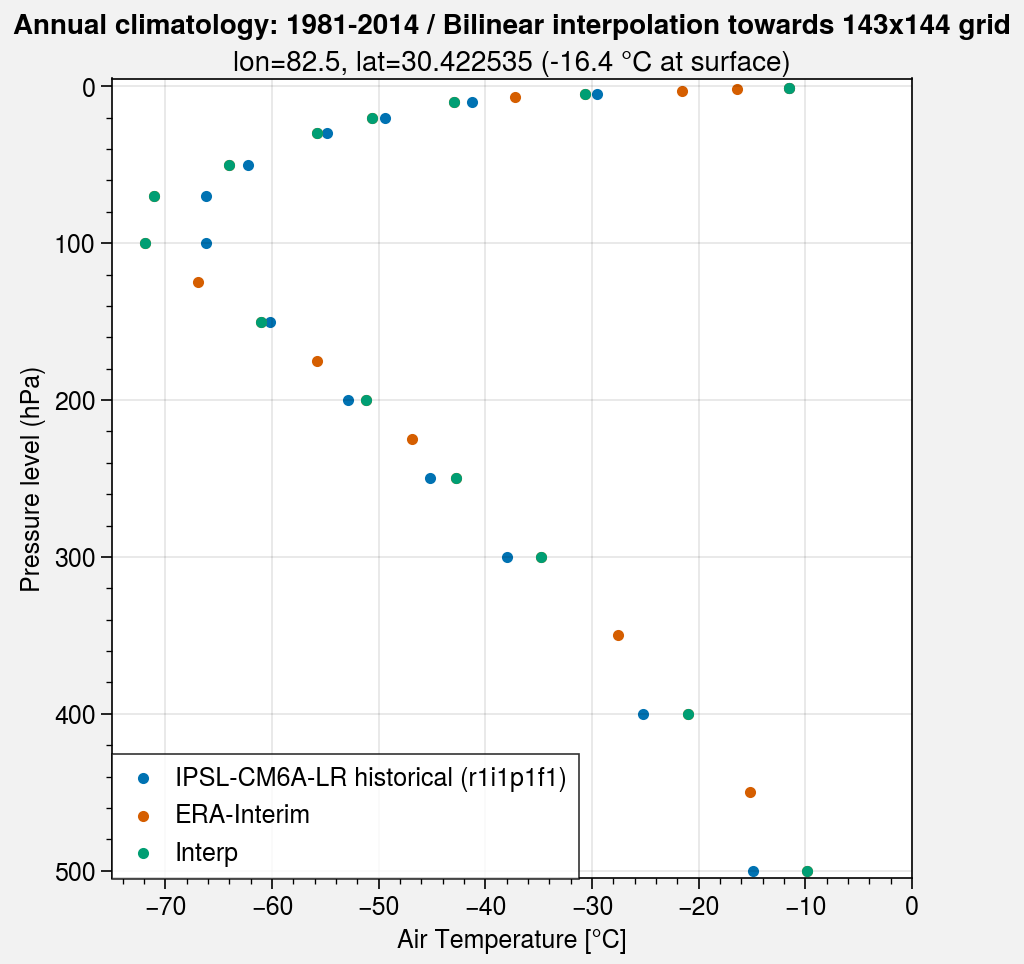

In [45]:
interp = ta_era_regrid_clim_masked.sel(lat=30.422535).dropna('level').interp(
    level=(ta_clim.plev.values/100), 
    method='linear'
)


fig, axs = plot.subplots(nrows=1, ncols=1, axwidth=4)

h1 = axs[0].scatter(ta_clim.sel(lat=30.422535).values, ta_clim.plev.values/100, label='IPSL-CM6A-LR historical (r1i1p1f1)')
h2 = axs[0].scatter(ta_era_regrid_clim_masked.sel(lat=30.422535).values, ta_era_regrid_clim.level.values, label='ERA-Interim')
h3 = axs[0].scatter(interp.values, interp.level.values, label='Interp', zorder=10)


hs = [h1, h2, h3]

axs[0].legend(hs, ncols=1)
axs[0].format(title='lon=82.5, lat=30.422535 (-16.4 °C at surface)')

axs.format(
    ylim=(500+5,0-5), xlim=(-75,0), 
    xlabel='Air Temperature [°C]', ylabel='Pressure level (hPa)',
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid",
)
